In [1]:
import os 
import xarray as xr
import numpy as np
import glob
import pandas as pd
from sklearn.cluster import KMeans, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, normalize
import itertools
from numpy.lib.stride_tricks import sliding_window_view
import datetime
from matplotlib import pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter)


In [2]:
project_dir = '/Users/huripari/Documents/PhD/TCs_Genesis'
data_dir = os.path.join(project_dir, 'data')

# Asbolute vorticity -> level adjustment
var = 'abs_vo'
dataset = 'ERA5dv'
vars_group = 'AV'
level = 850

var = 'rh'
dataset = 'ERA5'
vars_group = 'rh'
level = 700

basin = 'GLB'
n_clusters = 18
norm = False
seasonal_soothing = False
train_yearI, train_yearF = 1980, 2014
test_yearI, test_yearF = 2014, 2021
res = 2.5
resolution = f'{res}x{res}'
if dataset == 'ERA5':
    path_predictor = os.path.join(data_dir, dataset, resolution, vars_group, dataset + '_' + vars_group)
else:
    path_predictor = os.path.join(data_dir, dataset, resolution, vars_group, vars_group)

In [3]:
# Data extraction from .nc files
for y, year in enumerate(range(train_yearI, train_yearF+1)):
    path = path_predictor + f'_{resolution}_{year}.nc'
    if y == 0:
        train_data = xr.open_dataset(path)[var]
    else:
        train_data = xr.concat([train_data, xr.open_dataset(path)[var]], dim='time')
for y, year in enumerate(range(test_yearI, test_yearF+1)):
    path = path_predictor + f'_{resolution}_{year}.nc'
    if y == 0:
        test_data = xr.open_dataset(path)[var]
    else:
        test_data = xr.concat([test_data, xr.open_dataset(path)[var]], dim='time')
if (level != None) and (type(level) == int):
    train_data = train_data.sel(level=level)
    test_data = test_data.sel(level=level)
    var_name = train_data.long_name + ' at ' + str(level) + ' hPa'
elif (level != None) and (type(level) == str):
    train_data = train_data.sel(diff_level=level)
    test_data = test_data.sel(diff_level=level)
    var_name = train_data.long_name + ' between ' + level.split('-')[1] + ' and ' + level.split('-')[0] + ' hPa'
else:
    var_name = train_data.long_name
total_data = xr.concat([train_data, test_data], dim='time')

In [4]:
# Reshape the data -> (time, lat, lon) -> (lat*lon, time)
data = train_data.values
data_res = data.reshape(data.shape[0], data.shape[1]*data.shape[2]).T

# Mask the data if is a variable defined over the ocean
ocean_vars = ['sst', 'ssta20', 'ssta30', 'mpi']
if var in ocean_vars:
    ocean_mask = ~np.any(np.isnan(data_res), axis=1)
else:
    ocean_mask = None

mask = ocean_mask
data_res_masked = data_res[mask]

# Normalize each time series
if norm==True:
    data_res_masked = normalize(data_res_masked, axis=1, copy=True, return_norm=False)

In [5]:
# Perform clustering
from clustering import cluster_model
cluster = cluster_model(data_res_masked, n_clusters, var)
cluster.check_data()
cluster.kmeans()

Data is a 2D numpy array
Please, be sure the data is in the correct format: (n_samples (nodes), n_features (variables (time))


Index of the closest cluster center for each sample [2324, 3033, 1891, 800, 452, 3317, 170, 3, 433, 1613, 2821, 194, 2236, 1432, 2595, 306, 355, 2861]
Index of the closest cluster center for each sample [2324, 3033, 1891, 800, 452, 3317, 170, 3, 433, 1613, 2821, 194, 2236, 1432, 2595, 306, 355, 2861]


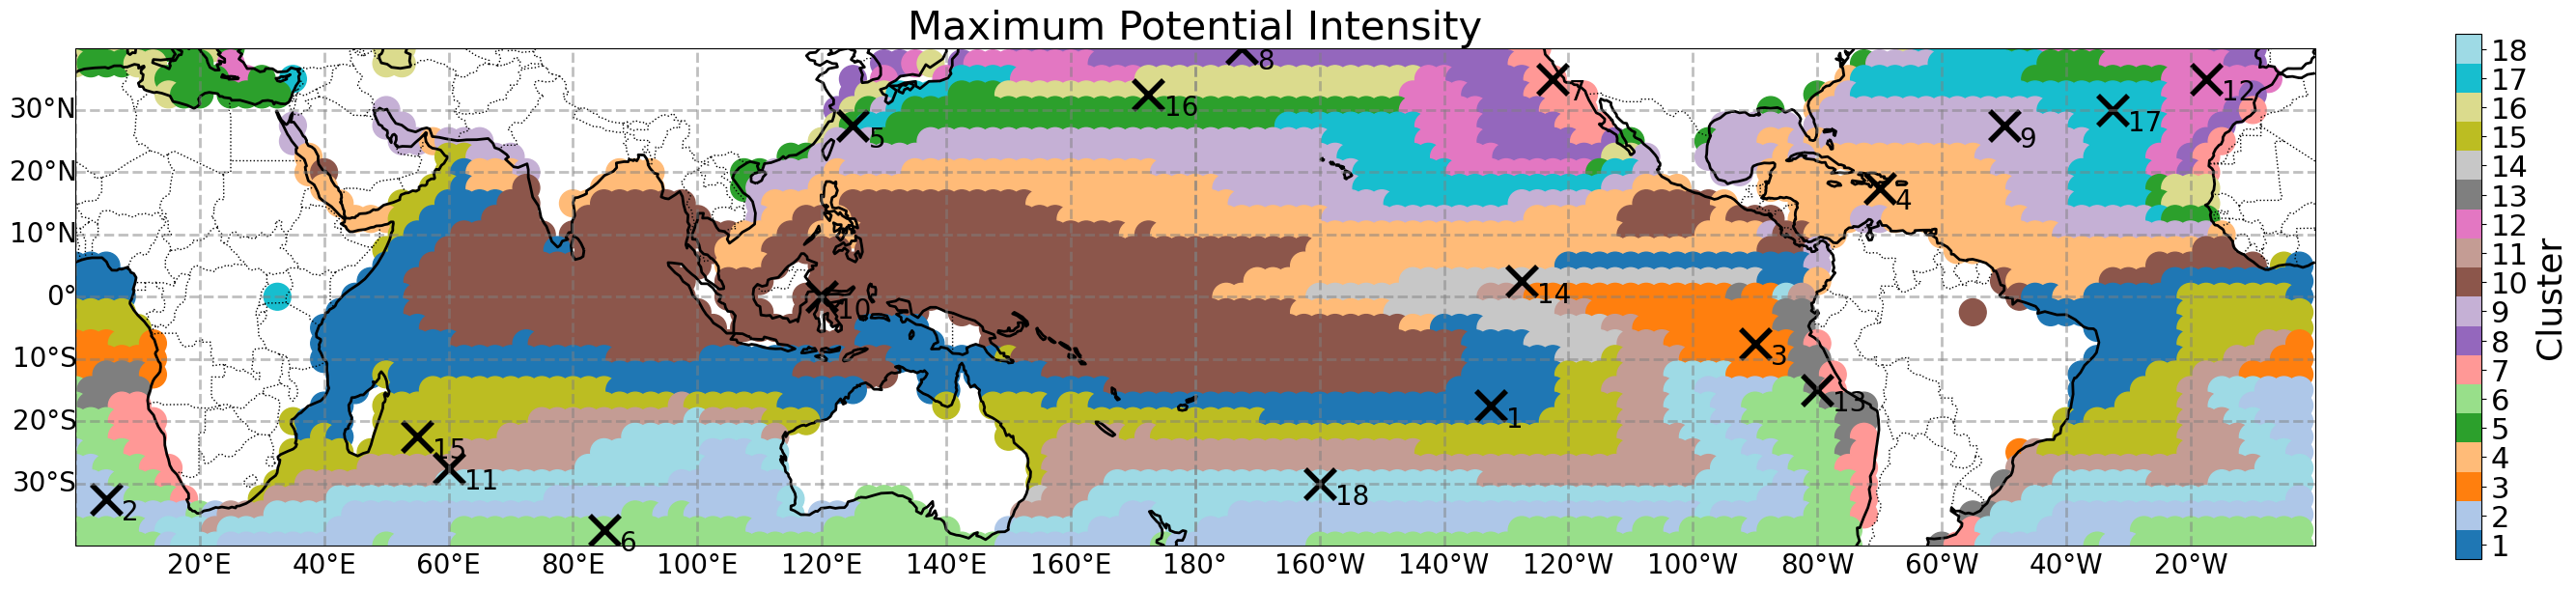

In [6]:
# Get the closest node to the cluster center
centroids = cluster_model.get_closest2center2(cluster, data_res_masked)
# Plot the clusters
latitudes = train_data.latitude.values
longitudes = train_data.longitude.values
cluster_model.plot_clusters(cluster, data_res_masked, latitudes, longitudes, mask, var_name)

In [7]:
# Get the data for the centroids 
iter = itertools.product(latitudes, longitudes)
nodes_list = np.array(list(iter))[mask]
lons_c = [np.array(nodes_list)[centroids][i][1] for i in range(len(np.array(nodes_list)[centroids]))]
lats_c = [np.array(nodes_list)[centroids][i][0] for i in range(len(np.array(nodes_list)[centroids]))]

In [8]:
# All filtering process of test data is skipped for now
data_filtered_total = total_data

In [9]:
# Create a dataframe with the centroids time series
centroids_data = []
for i in range(len(centroids)):
    centroid_data = data_filtered_total.sel(latitude=lats_c[i], longitude=lons_c[i]).values
    centroids_data.append(centroid_data)
centroids_dataframe = pd.DataFrame(centroids_data).T
centroids_dataframe.index = data_filtered_total.time.values
centroids_dataframe.columns = [var + basin + '_cluster' + str(i) for i in range(1, n_clusters+1)]

In [10]:
# Get average data for each cluster, weighted averages are calculated. Batch size is adjusted to avoid memory errors
clusters_av_dataframe = pd.DataFrame(columns=[var + basin + '_cluster' + str(i) for i in range(1, n_clusters+1)])
weights = np.cos(np.deg2rad(nodes_list[:,0]))
data_cluster_avg = data_filtered_total.values

def weighted_average(data, weights):
    weighted_sum = np.dot(weights, data)
    total_weight = np.sum(weights)
    return weighted_sum / total_weight

def calculate_weighted_average(data, weights, batch_size):
    num_rows = data.shape[0]
    result = np.zeros((data.shape[1],))
    
    for i in range(0, num_rows, batch_size):
        if i + batch_size > num_rows:
            batch_data = data[i:]
            batch_weights = weights[i:]
        else:
            batch_data = data[i:i+batch_size]
            batch_weights = weights[i:i+batch_size]
        result += weighted_average(batch_data, batch_weights)
        
    return result / (num_rows/batch_size)

for c in range(len(centroids)):
    cluster_mask = cluster.labels == c
    batch_size = 100
    data_cluster_avg_masked = data_cluster_avg.reshape(data_cluster_avg.shape[0], data_cluster_avg.shape[1]*data_cluster_avg.shape[2]).T[mask][cluster_mask]
    weights_masked = weights[cluster_mask]
    cluster_avg = calculate_weighted_average(data_cluster_avg_masked, weights_masked, batch_size)
    clusters_av_dataframe[var + basin + '_cluster' + str(c+1)] = cluster_avg

clusters_av_dataframe.index = data_filtered_total.time.values

In [11]:
# Create a dataframe with the cluster labels
labels_dataframe = pd.DataFrame(cluster.labels, columns=['cluster'])
labels_dataframe['nodes_lat'] = np.array(nodes_list)[:,0]
labels_dataframe['nodes_lon'] = np.array(nodes_list)[:,1]
labels_dataframe['cluster'] = labels_dataframe['cluster'] + 1